In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.arima_model import ARMA

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
arma_df = pd.read_csv(r'C:\Users\James Stanley\Documents\GitHub\backtest_utilities\data\daily\commodities\soft_commodities\grains\cotton\ICEUS_DLY_CT1!, 1D.csv',index_col='time', parse_dates=True)

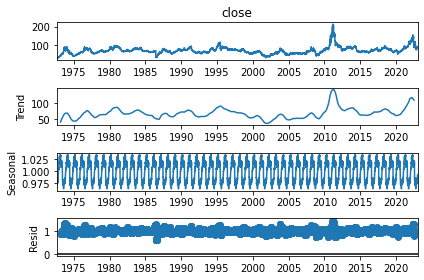

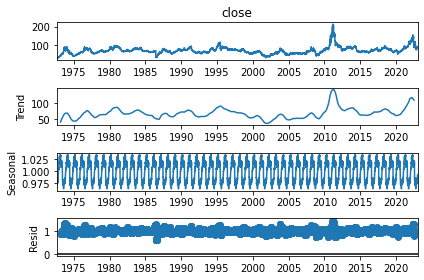

In [3]:
seasonal_result = seasonal_decompose(arma_df['close'], model="multiplicative",period=252)

trend    = seasonal_result.trend
seasonal = seasonal_result.seasonal
residual = seasonal_result.resid

seasonal_result.plot()

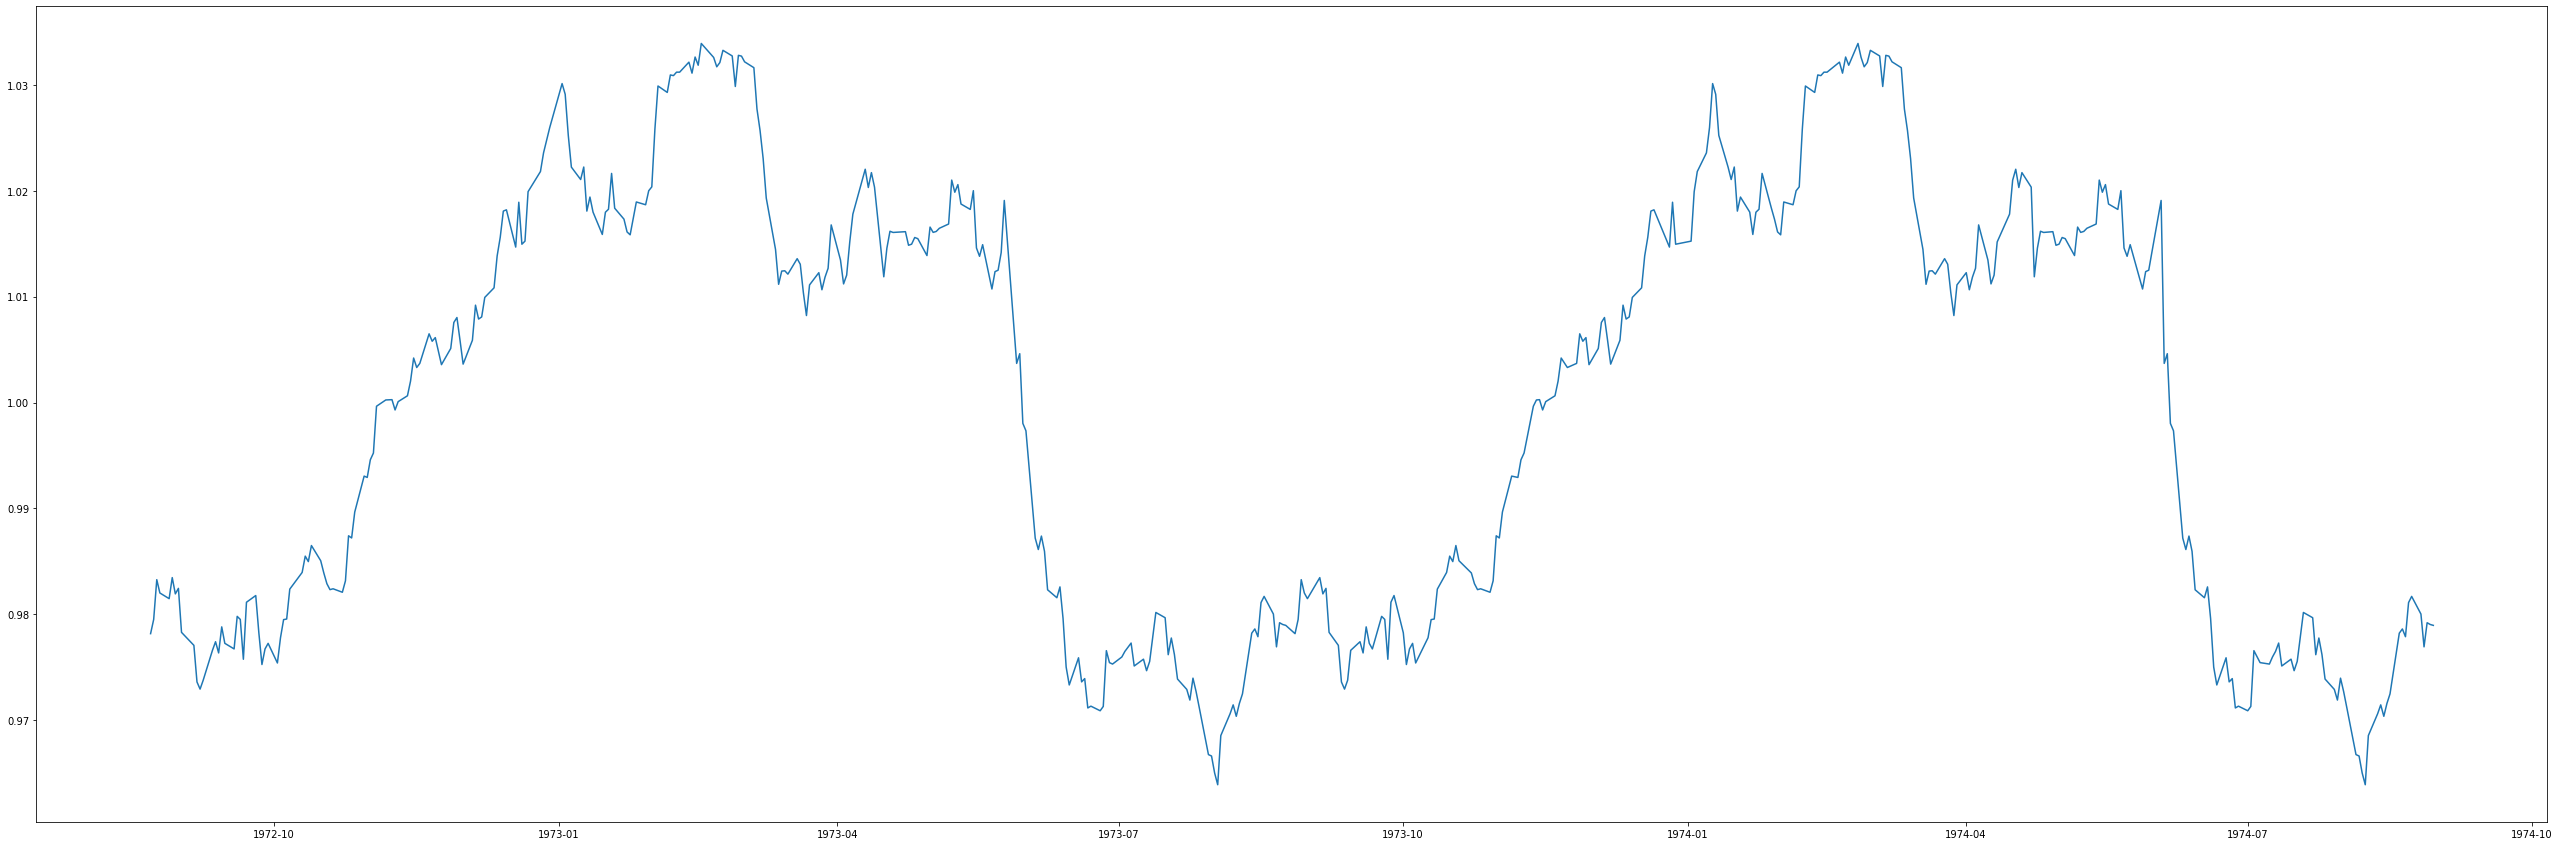

In [4]:
plt.figure(figsize=(45,15))

plt.plot(seasonal[0:504])

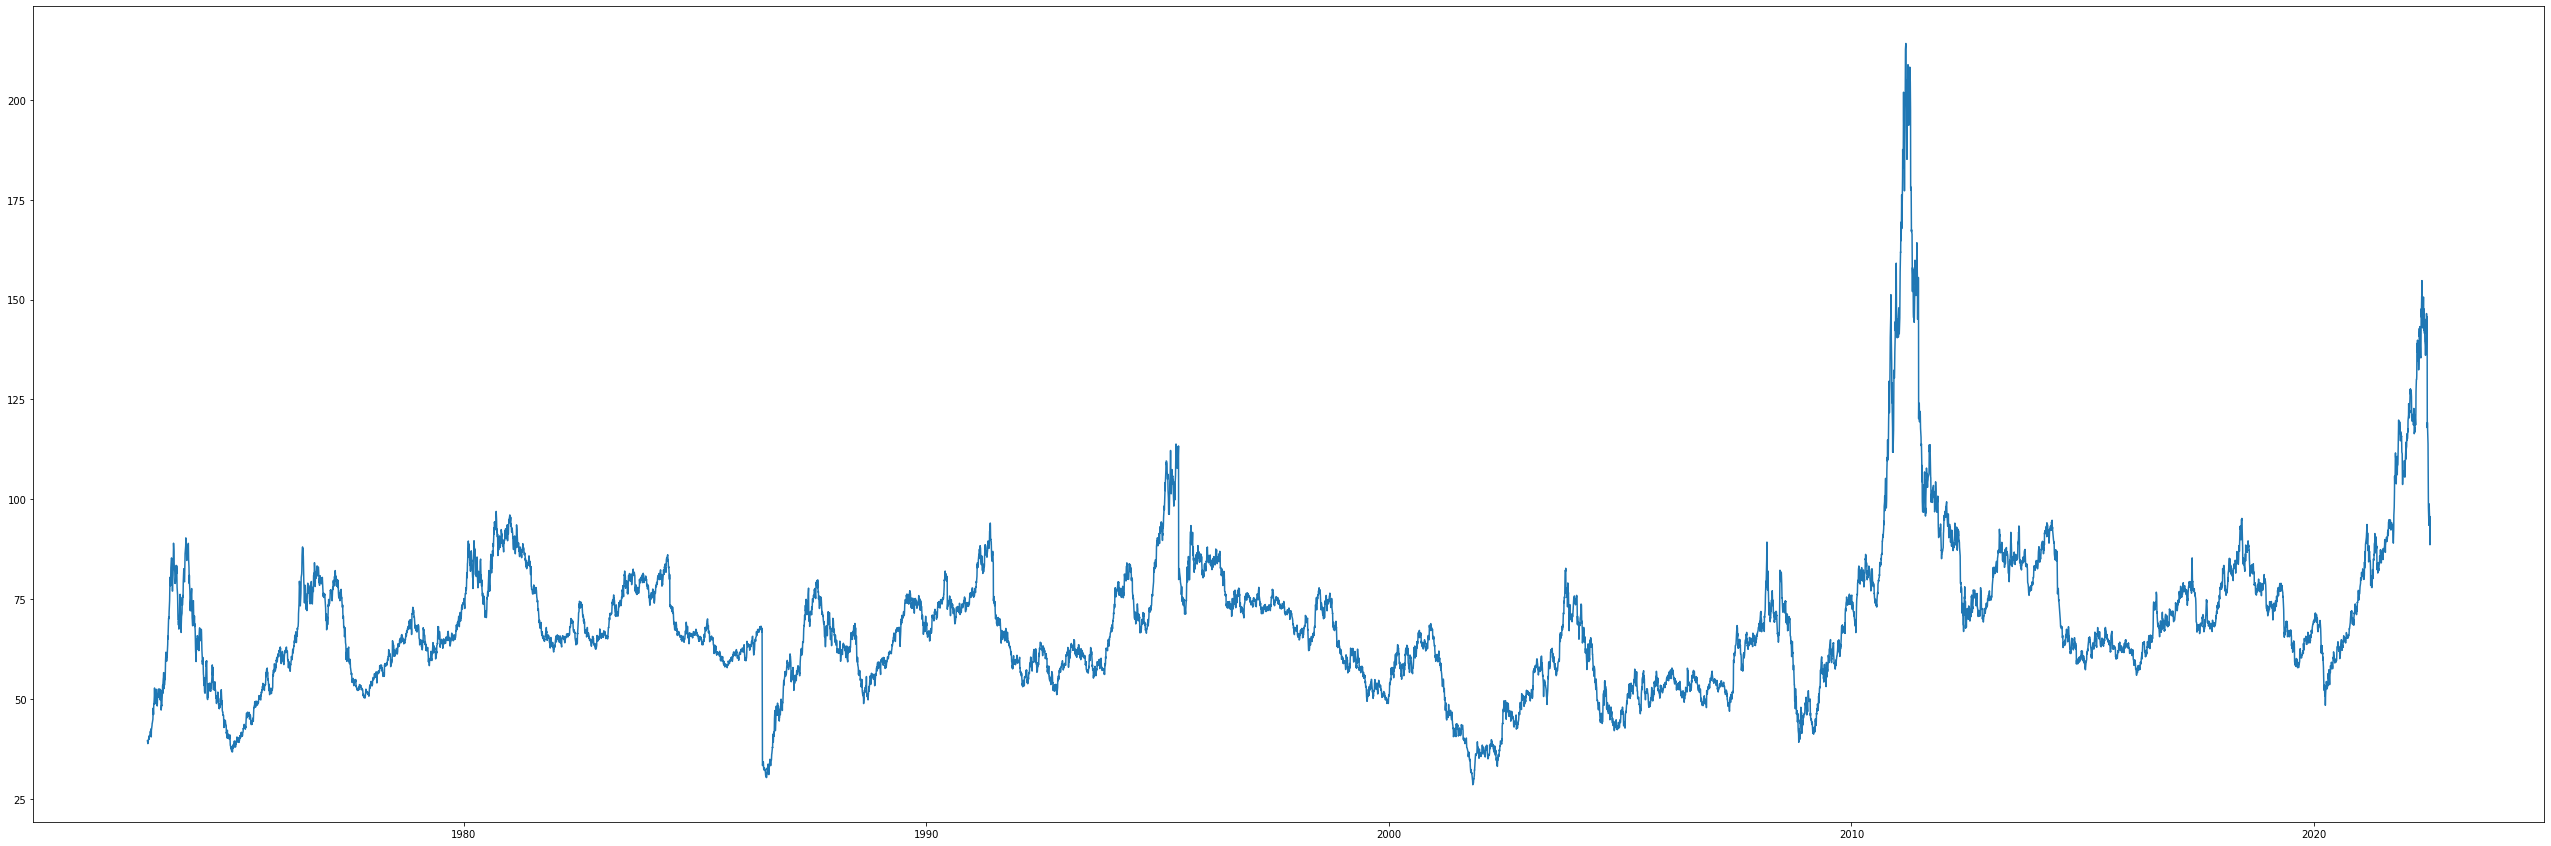

In [5]:
plt.figure(figsize=(45,15))

plt.plot(trend*residual*seasonal)

plt.show()

In [6]:
residual.dropna(axis=0)

time
1973-02-27 02:00:00+00:00    0.910200
1973-02-28 02:00:00+00:00    0.896743
1973-03-01 02:00:00+00:00    0.890224
1973-03-02 02:00:00+00:00    0.878859
1973-03-05 02:00:00+00:00    0.880972
                               ...   
2022-07-01 01:00:00+00:00    0.872402
2022-07-05 01:00:00+00:00    0.837930
2022-07-06 01:00:00+00:00    0.795100
2022-07-07 01:00:00+00:00    0.825196
2022-07-08 01:00:00+00:00    0.859537
Name: resid, Length: 12397, dtype: float64

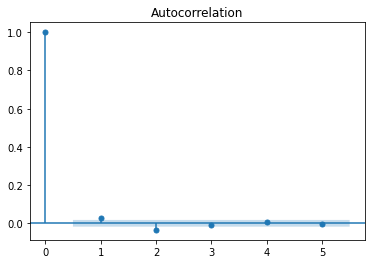

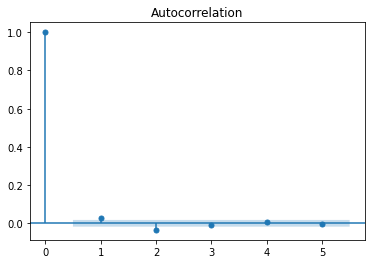

In [7]:
plot_acf(residual.dropna(axis=0).diff(1).dropna(axis=0),alpha=0.05, lags=5)

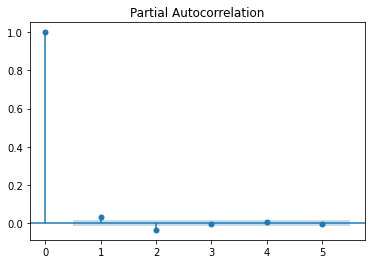

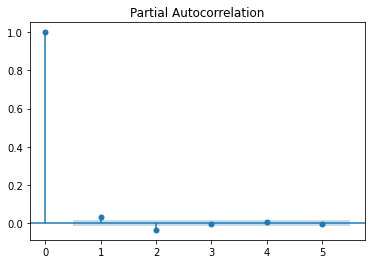

In [8]:
plot_pacf(residual.dropna(axis=0).diff(1).dropna(axis=0), alpha=0.05, lags=5)

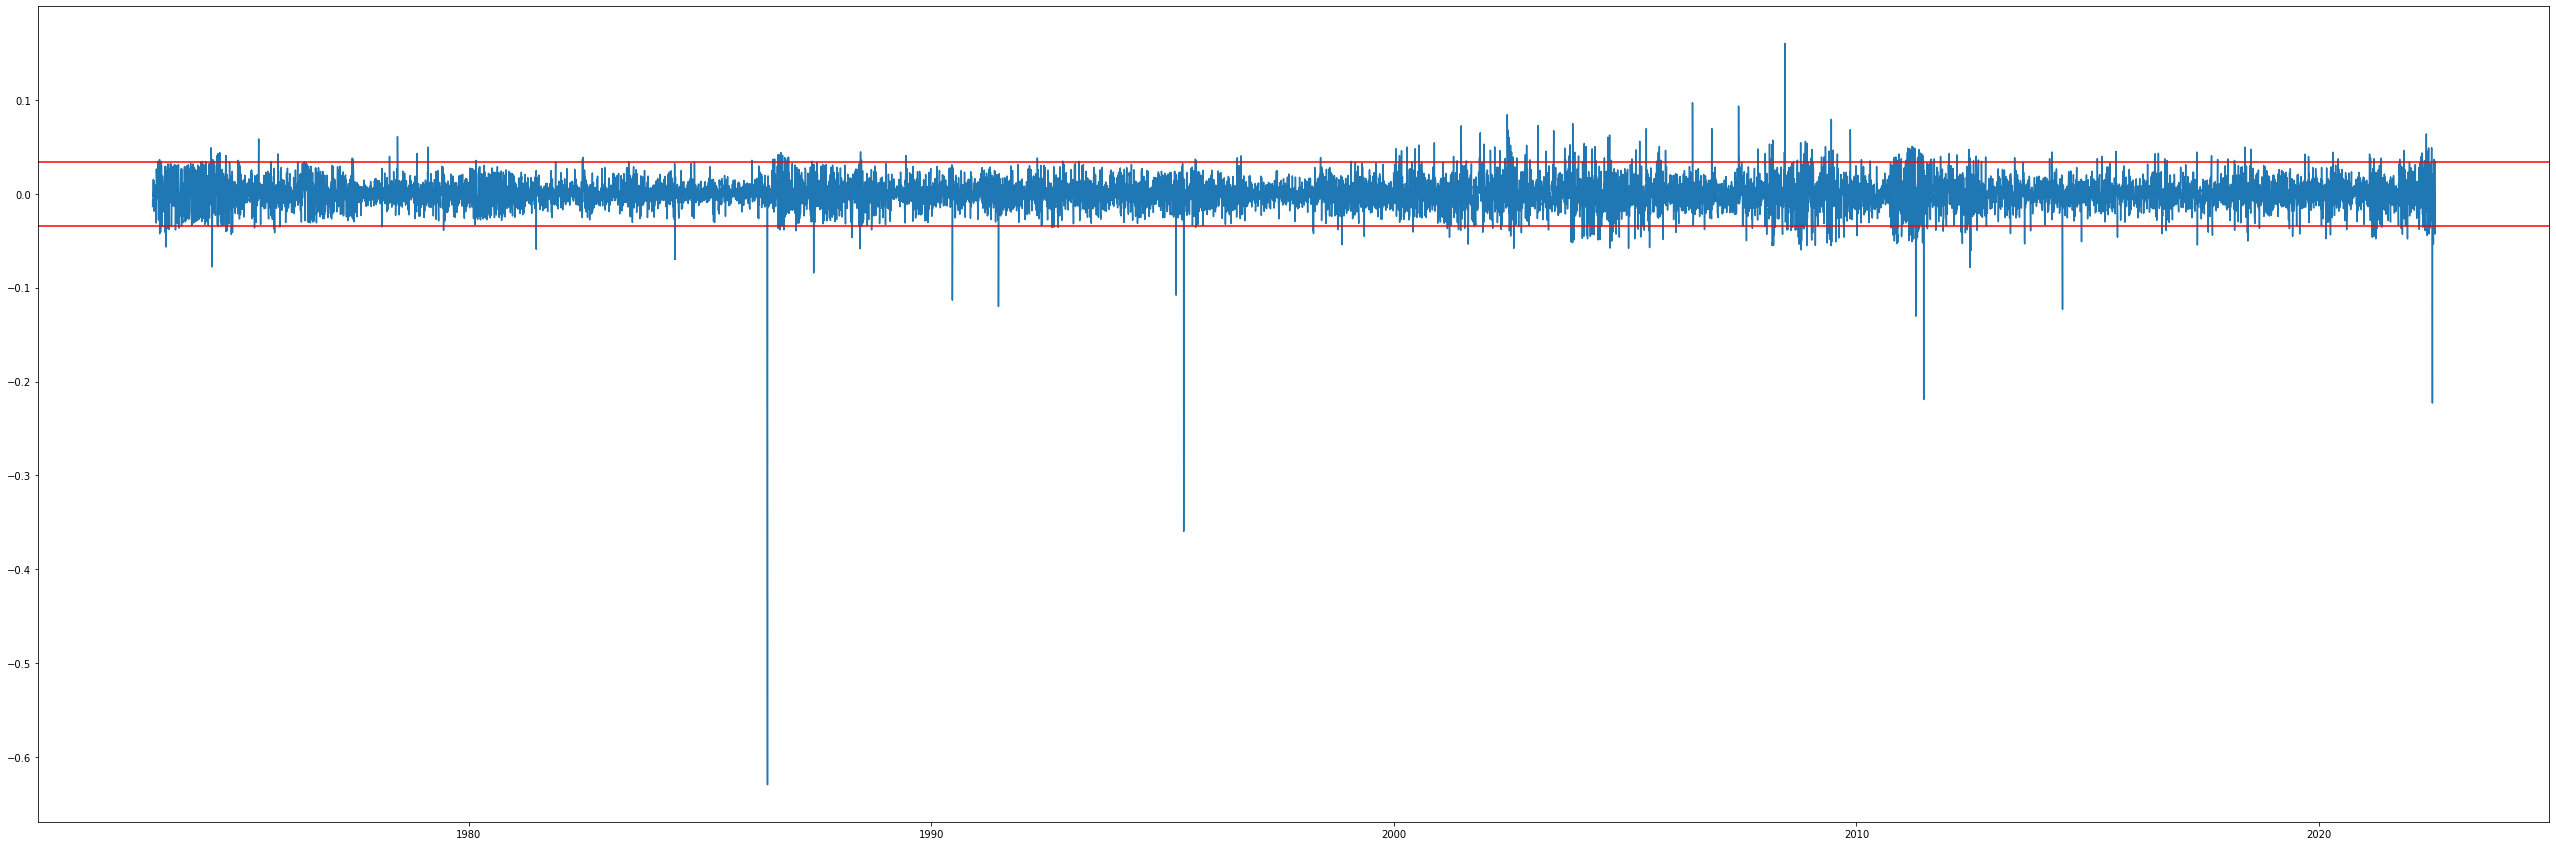

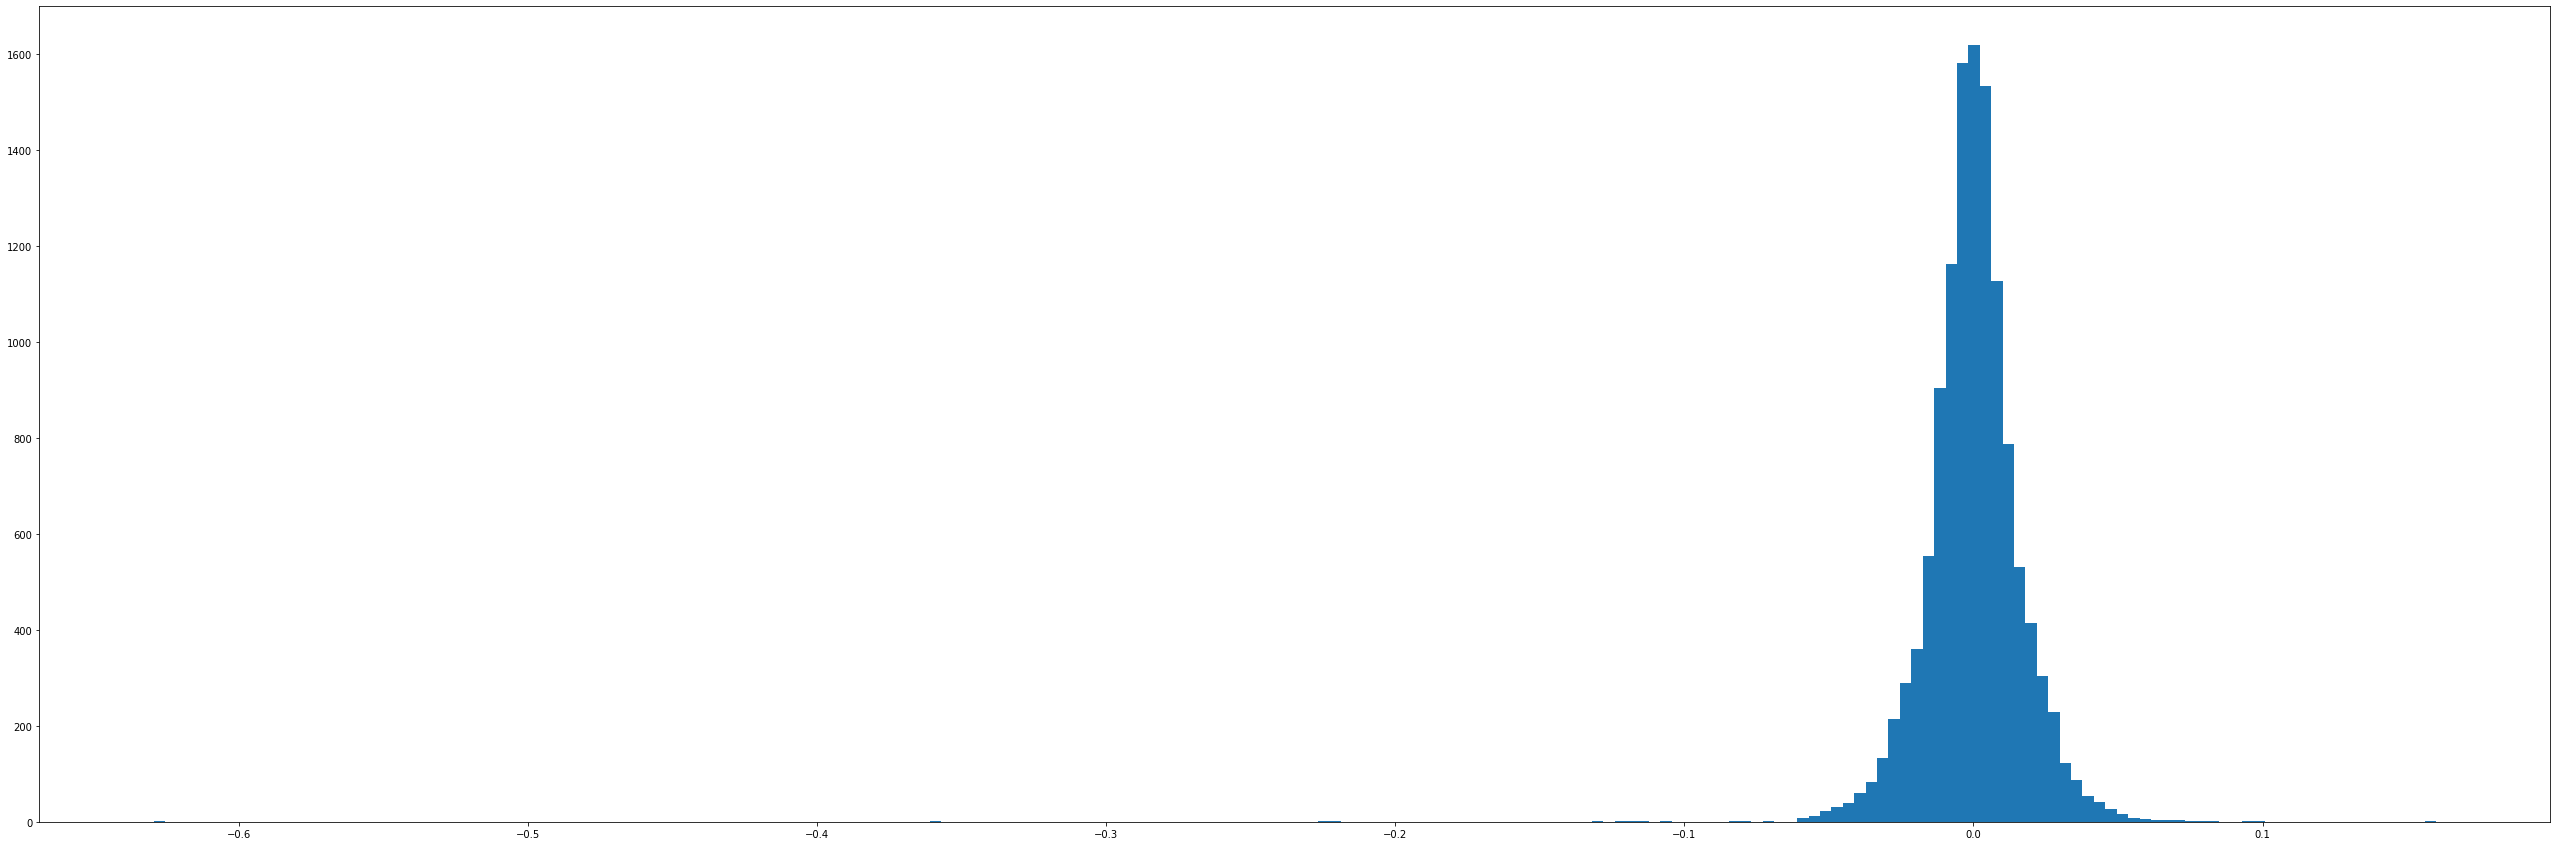

In [9]:
plt.figure(figsize=(45,15))

plt.plot(residual.dropna(axis=0).diff(1).dropna(axis=0))
plt.axhline(2*np.std(residual.dropna(axis=0).diff(1).dropna(axis=0)),color='red')
plt.axhline(-2*np.std(residual.dropna(axis=0).diff(1).dropna(axis=0)),color='red')
plt.show()

plt.figure(figsize=(45,15))

plt.hist(residual.dropna(axis=0).diff(1).dropna(axis=0),bins=200)

plt.show()

In [10]:
import os
import sys

import numpy as np
import pandas as pd

from datetime import datetime
from statsmodels.tsa.arima_model import ARMA

class train_arma:
    
    def __init__(self, event):

        # Read in dataframe
        self.dataframe       = pd.read_csv(event['dataframe'],parse_dates=True,index_col='time')

        # Training information
        self.forecastHorizon = event['forecastHorizon']
        self.trainDFLength   = event['trainDFLength']
        self.order           = event['order']
        self.diff            = event['diff']
        self.product         = event['product']
        self.column          = event['column']
        self.b_adjust        = event['b_adjust']

        # number of mdoels to be trained
        self.num_models      = event['num_models']

        # store l of forecast
        self.forecastList    = []

    def arma_model(self):

        cacheForecasts = {

            'asofdate':[],
            'pointForecast':[],
            self.column:[],
            'forecastday':[],
            'product_name':[],
            'MA_50':[],
            'MA_diff_50':[],


        }

        cacheMetadata = {

            'asofdate':[],
            'aic':[],
            'bic':[],
            'hqic':[],
            'mae':[],
            'mse':[],
            'forecastHorizon':[],
            'diff':[],
            'trainDFLength':[],
            'num_models':[],
            'order_p':[],
            'order_q':[],
            'time':[],
            'product_name':[],

        }

        for param in range(1,1+self.order[0]):
            cacheMetadata[f'ar.L{param}.{self.column}'] = []

        for param in range(1,1+self.order[1]):
            cacheMetadata[f'ma.L{param}.{self.column}'] = []

        if self.diff:
            diff   = np.log(self.dataframe[self.column]).diff(1).dropna(axis=0)
    
            for j in range(1,self.forecastHorizon+1):
                self.forecastList.append(j)

            i = 0
            while i < self.num_models:

   
                try:
                    start = datetime.now()

                    # training the model
                    mod = ARMA(diff[i:self.trainDFLength+i], order=self.order)
                    res = mod.fit()
                    
                    # converting log forecast
                    fcast = res.forecast(self.forecastHorizon)

                    # Calculating forecasts
                    cacheForecasts['pointForecast'].append(np.exp(fcast[0])*self.dataframe[self.column][self.trainDFLength+i])
                    cacheForecasts[self.column].append(self.dataframe[self.column][self.trainDFLength+i+1:self.trainDFLength+self.forecastHorizon+i+1])

                    # store model metadata
                    cacheMetadata['asofdate'].append(self.dataframe.index[self.trainDFLength+i])
                    cacheMetadata['aic'].append(res.aic)
                    cacheMetadata['bic'].append(res.bic)
                    cacheMetadata['hqic'].append(res.hqic)
                    cacheMetadata['mae'].append(np.mean(np.abs(res.resid)))
                    cacheMetadata['mse'].append(np.mean(np.square(res.resid)))

                    # event_data
                    cacheMetadata['forecastHorizon'].append(self.forecastHorizon)
                    cacheMetadata['diff'].append(self.diff)
                    cacheMetadata['trainDFLength'].append(self.trainDFLength)
                    cacheMetadata['num_models'].append(self.num_models)
                    cacheMetadata['order_p'].append(self.order[0])
                    cacheMetadata['order_q'].append(self.order[1])
                    cacheMetadata['product_name'].append(self.product)

                    for param in range(1,1+self.order[0]):
                        cacheMetadata[f'ar.L{param}.{self.column}'].append(res.bse[f'ar.L{param}.{self.column}'])

                    for param in range(1,1+self.order[1]):
                        cacheMetadata[f'ma.L{param}.{self.column}'].append(res.bse[f'ma.L{param}.{self.column}'])

                    cacheMetadata['time'].append(datetime.now() - start)

                except:
                    cacheForecasts['pointForecast'].append(self.dataframe[self.column][self.trainDFLength+i+1:self.trainDFLength+self.forecastHorizon+i+1])

                i+=self.forecastHorizon

            # Fixing data formats
            cacheForecasts['pointForecast'] = np.concatenate(cacheForecasts['pointForecast'])
            cacheForecasts['forecastday']   = np.array(self.forecastList*(int(len(cacheForecasts['pointForecast'])/int(self.forecastHorizon))))
            cacheForecasts[self.column]     = np.array(self.dataframe[self.column][1+self.trainDFLength:1+self.trainDFLength+len(cacheForecasts['pointForecast'])])
            cacheForecasts['asofdate']      = np.array(self.dataframe[self.column][1+self.trainDFLength:1+self.trainDFLength+len(cacheForecasts['pointForecast'])].index)
            cacheForecasts['product_name']  = np.array([self.product]*int(len(cacheForecasts['pointForecast'])))
            cacheForecasts['MA_50']         = self.dataframe[self.column].rolling(50).mean()[1+self.trainDFLength:1+self.trainDFLength+len(cacheForecasts['pointForecast'])]
            cacheForecasts['MA_diff_50']    = self.dataframe[self.column].rolling(50).mean().diff(1)[1+self.trainDFLength:1+self.trainDFLength+len(cacheForecasts['pointForecast'])]

            
            pd.DataFrame(cacheForecasts).to_csv(f'forecasts_{self.product}_{self.order}_{self.diff}_{self.forecastHorizon}.csv')
            pd.DataFrame(cacheMetadata).to_csv(f'metadata_{self.product}_{self.order}_{self.diff}_{self.forecastHorizon}.csv')

In [11]:
residual.dropna(axis=0).to_csv(r'residuals.csv')

In [12]:
len(pd.read_csv(r'C:\Users\James Stanley\Documents\GitHub\backtest_utilities\approved_projects\seasonal_arma\residuals.csv')) - 252


12145

In [13]:
arma_model_event = {

    'dataframe':r'C:\Users\James Stanley\Documents\GitHub\backtest_utilities\approved_projects\seasonal_arma\residuals.csv',
    'forecastHorizon':5,
    'trainDFLength':252,
    'order':(2,2),
    'num_models':2000,
    'diff':True,
    'product':'CT1',
    'column':'resid',
    'b_adjust':True,

}

In [14]:
model = train_arma(arma_model_event)
model.arma_model()


c:\Users\James Stanley\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\Users\James Stanley\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueW

In [15]:
forecast_df = pd.read_csv(r'C:\Users\James Stanley\Documents\GitHub\backtest_utilities\approved_projects\seasonal_arma\forecasts_CT1_(2, 2)_True_5.csv',parse_dates=True,index_col='asofdate')
residual_df =  pd.read_csv(r'C:\Users\James Stanley\Documents\GitHub\backtest_utilities\approved_projects\seasonal_arma\residuals.csv',parse_dates=True,index_col='time')

In [16]:
forecast_df.head()

,time,pointForecast,resid,forecastday,product_name,MA_50,MA_diff_50
asofdate,,,,,,,
1974-03-06 01:00:00+00:00,1974-03-06 01:00:00+00:00,1.017313,0.992360,1,CT1,1.111143,-0.003614
1974-03-07 01:00:00+00:00,1974-03-07 01:00:00+00:00,1.013336,0.974742,2,CT1,1.106674,-0.004469
1974-03-08 01:00:00+00:00,1974-03-08 01:00:00+00:00,1.011521,0.986481,3,CT1,1.101987,-0.004687
1974-03-11 01:00:00+00:00,1974-03-11 01:00:00+00:00,1.011053,0.962637,4,CT1,1.096177,-0.005811
1974-03-12 01:00:00+00:00,1974-03-12 01:00:00+00:00,1.011217,0.939312,5,CT1,1.089443,-0.006734


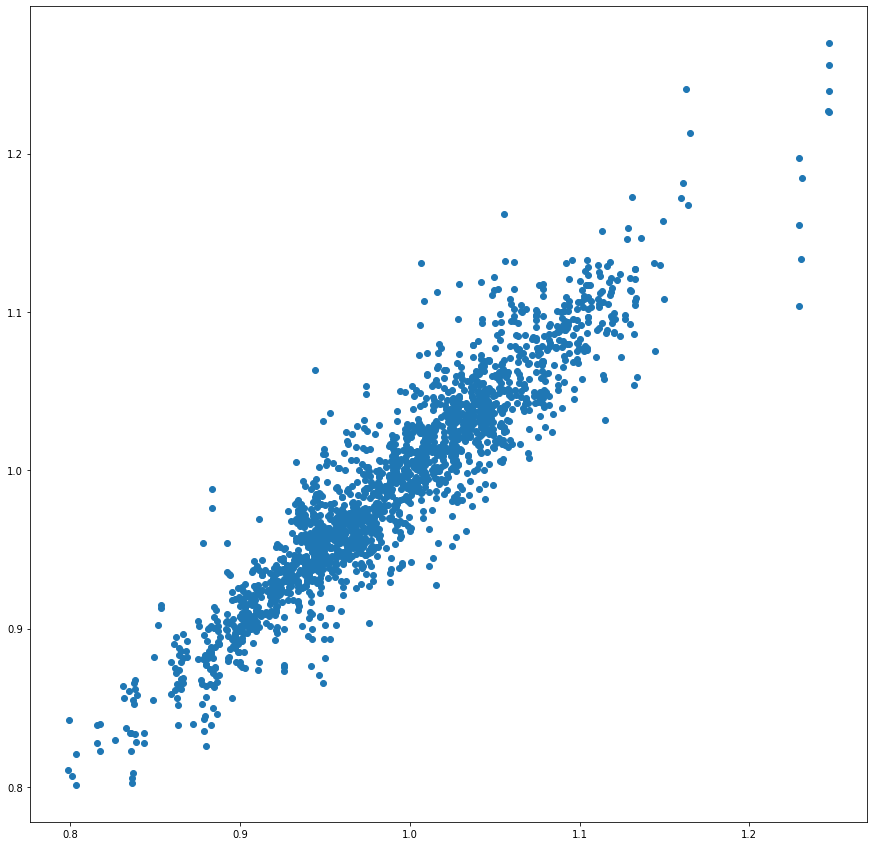

In [19]:
plt.figure(figsize=(15,15))

plt.scatter(forecast_df['pointForecast'],forecast_df['resid'])

plt.show()

In [20]:
trend = trend.dropna(axis=0).reset_index().set_index('time')
# seasonal.reset_index().set_index(['time'])

In [23]:
merge_df = pd.concat([forecast_df['pointForecast'],trend['trend'],seasonal.reset_index().set_index(['time'])['seasonal']],axis=1)
merge_df['seasonal_estimate'] = merge_df['pointForecast']*merge_df['trend']*merge_df['seasonal']
forecast_merged_df = pd.concat([merge_df['seasonal_estimate'],arma_df['close']],axis=1)
forecast_merged_df = forecast_merged_df.dropna(axis=0)

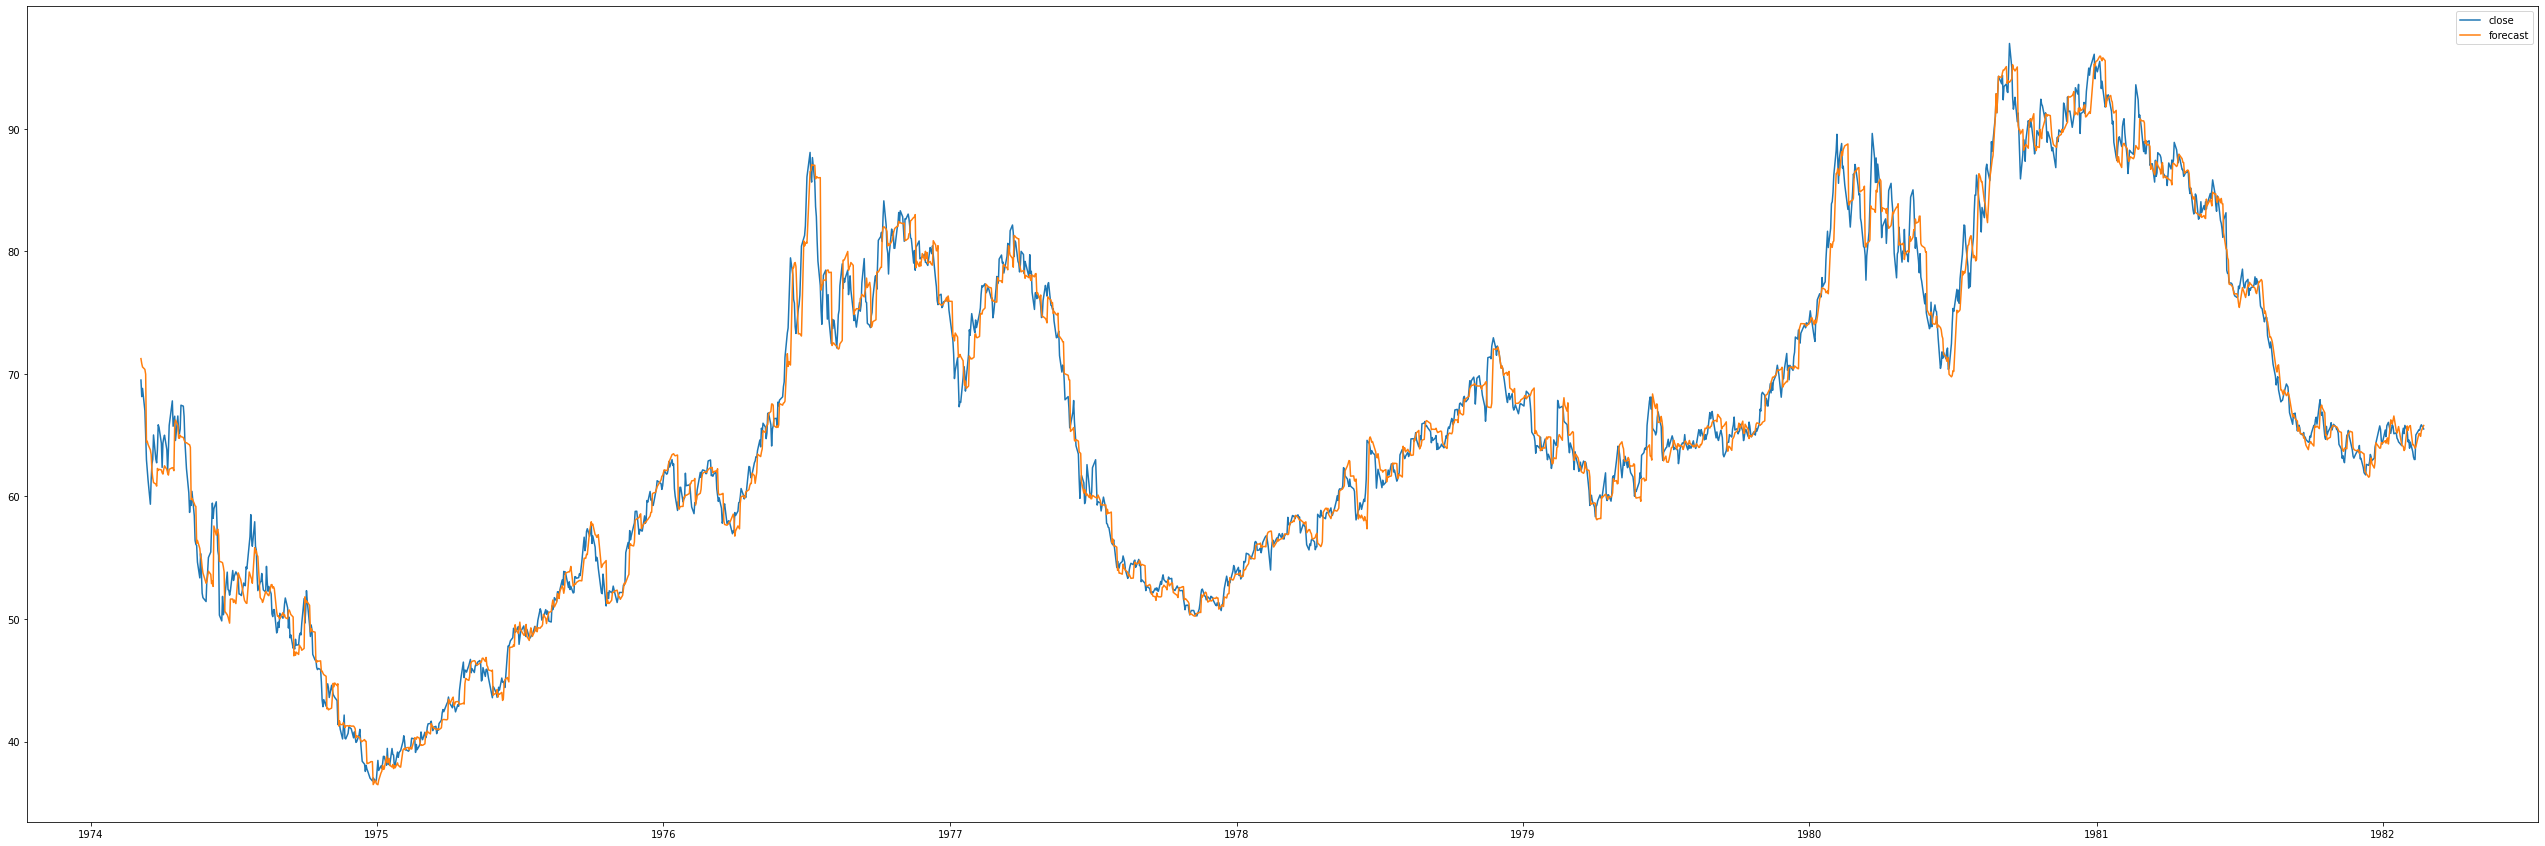

In [28]:
plt.figure(figsize=(45,15))
plt.plot(forecast_merged_df['close'])
plt.plot(forecast_merged_df['seasonal_estimate'])

plt.legend(['close','forecast'])
plt.show()

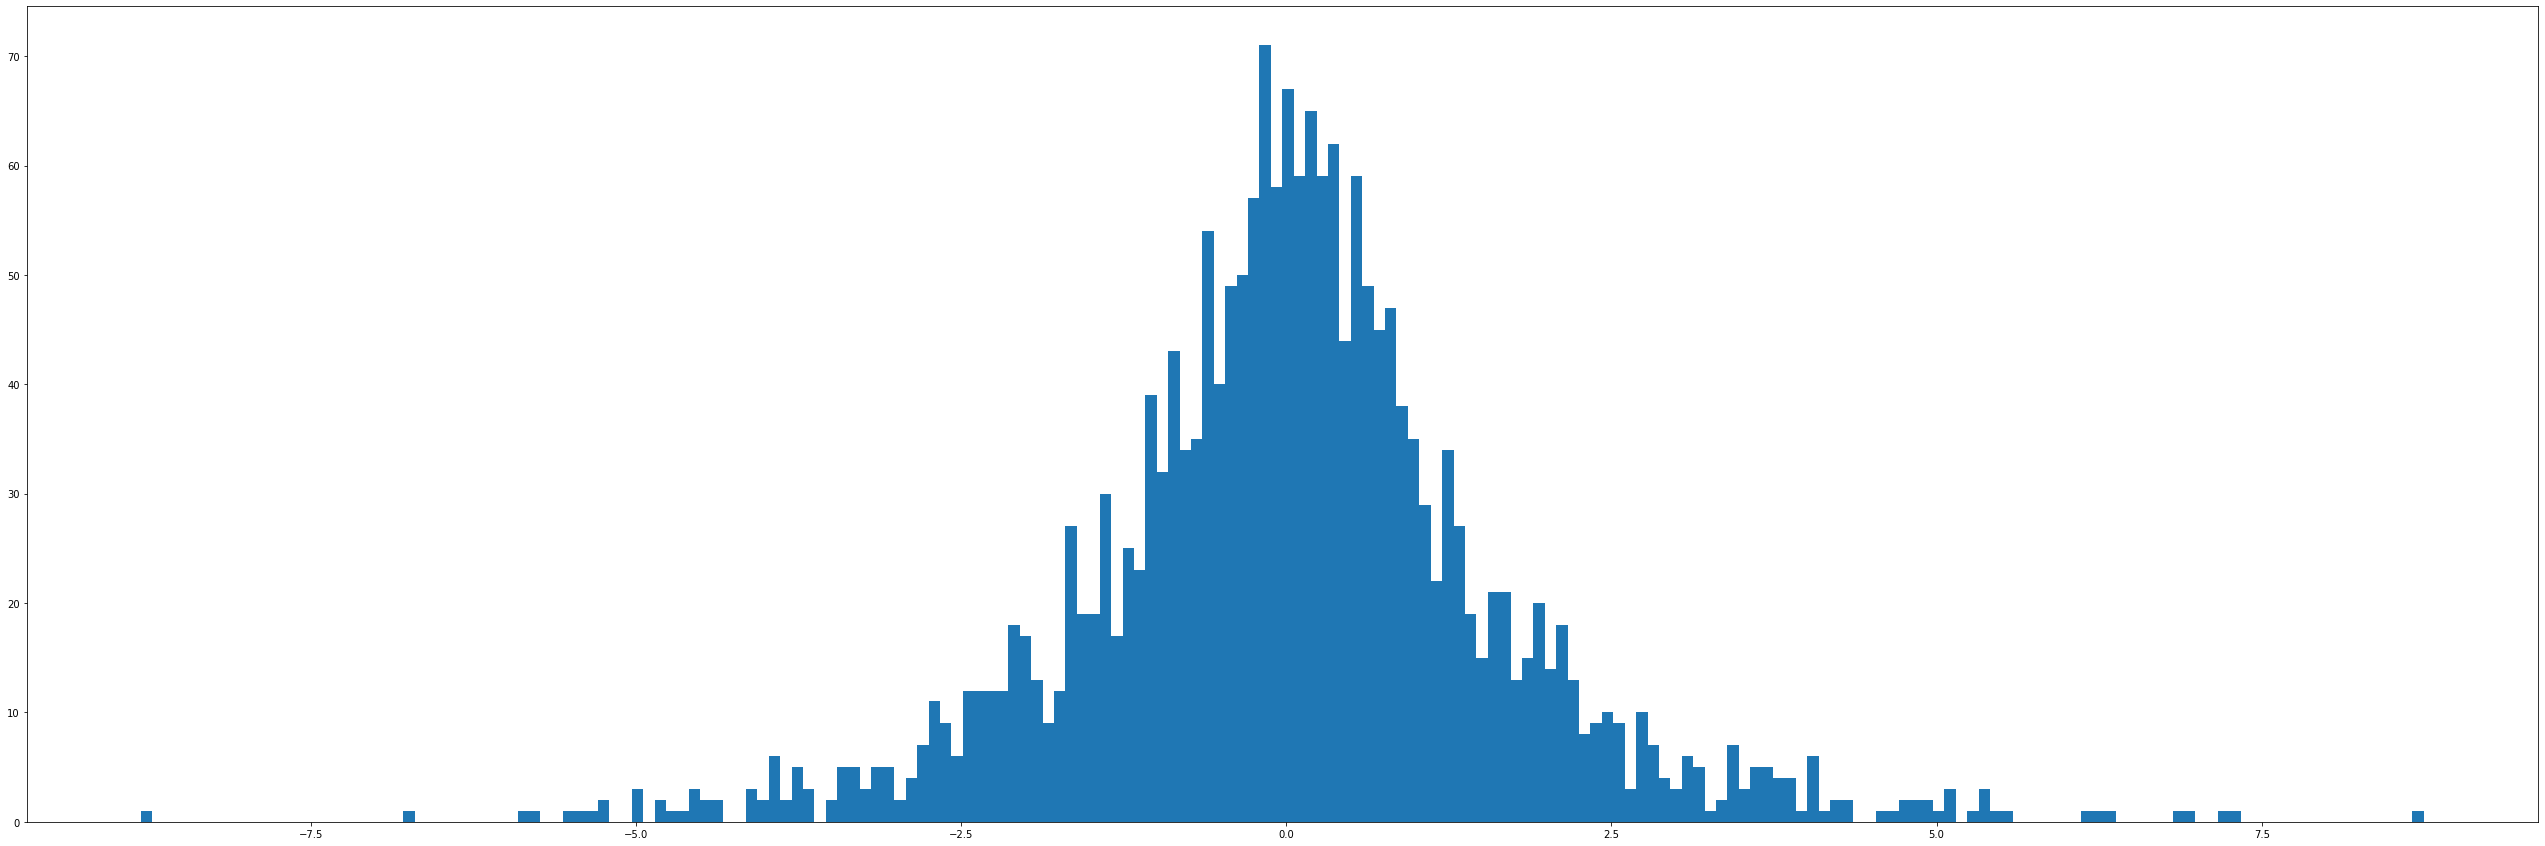

In [29]:
plt.figure(figsize=(45,15))
plt.hist((forecast_merged_df['close'] - forecast_merged_df['seasonal_estimate']).reset_index()[0],bins=200)
plt.show()

In [30]:

pnl_event = {

    'forecastHorizon':5,
    'dataframe':r'C:\Users\James Stanley\Documents\GitHub\backtest_utilities\approved_projects\seasonal_arma\forecasts_CT1_(2, 2)_True_5.csv',
    'threshold':0.01,
    'reinvest':True,
    'strategy':'arma_threshold_ma',
}


In [31]:
fcast_df = pd.read_csv(r'C:\Users\James Stanley\Documents\GitHub\backtest_utilities\approved_projects\seasonal_arma\forecasts_CT1_(2, 2)_True_5.csv',parse_dates=True,index_col='time')

In [32]:
fcast_df.head(5)

,asofdate,pointForecast,resid,forecastday,product_name,MA_50,MA_diff_50
time,,,,,,,
1974-03-06 01:00:00+00:00,1974-03-06 01:00:00+00:00,1.017313,0.992360,1,CT1,1.111143,-0.003614
1974-03-07 01:00:00+00:00,1974-03-07 01:00:00+00:00,1.013336,0.974742,2,CT1,1.106674,-0.004469
1974-03-08 01:00:00+00:00,1974-03-08 01:00:00+00:00,1.011521,0.986481,3,CT1,1.101987,-0.004687
1974-03-11 01:00:00+00:00,1974-03-11 01:00:00+00:00,1.011053,0.962637,4,CT1,1.096177,-0.005811
1974-03-12 01:00:00+00:00,1974-03-12 01:00:00+00:00,1.011217,0.939312,5,CT1,1.089443,-0.006734


In [33]:
test_df = (forecast_merged_df['close'] - forecast_merged_df['seasonal_estimate']).reset_index()[0]

In [34]:
forecast_merged_df

,seasonal_estimate,close
1974-03-06 01:00:00+00:00,71.247552,69.50
1974-03-07 01:00:00+00:00,70.848342,68.15
1974-03-08 01:00:00+00:00,70.566849,68.82
1974-03-11 01:00:00+00:00,70.369819,67.00
1974-03-12 01:00:00+00:00,69.975735,65.00
...,...,...
1982-02-16 02:00:00+00:00,65.140281,65.45
1982-02-17 02:00:00+00:00,65.131673,65.42
1982-02-18 02:00:00+00:00,64.906616,65.72
1982-02-19 02:00:00+00:00,65.341857,65.85


In [35]:
save = forecast_merged_df

In [36]:
forecast_merged_df = save

In [37]:
forecast_merged_df.iloc[259]

seasonal_estimate    41.026259
close                41.250000
Name: 1975-03-17 01:00:00+00:00, dtype: float64

In [38]:
forecast_merged_df['ma'] = forecast_merged_df['close'].rolling(50).mean()

In [39]:
forecast_merged_df['MA_diff_50'] = forecast_merged_df['ma'].diff(1)

In [40]:
forecast_merged_df = forecast_merged_df.dropna(axis=0)

In [41]:
cachePnL = {

    'asofdate':[],
    'pnl':[],
    'strategy':[],
    'positionType':[],

}

# name of string to save output
cache_pnl_str = pnl_event['dataframe'].replace("forecasts","pnl_armaspreadthreshold")
cache_trades_str = pnl_event['dataframe'].replace("forecasts","tradelevelpnl_armaspreadthreshold")


# reading in dataframe
pnl_event['dataframe'] = forecast_merged_df.reset_index()

# calculating the difference
close_diff    = pnl_event['dataframe']['close'].diff(1).fillna(0) #.diff(pnl_event['forecastHorizon'])

forecast_diff = pnl_event['dataframe']['seasonal_estimate'].diff(pnl_event['forecastHorizon'])

i = 0
while i < len(pnl_event['dataframe']) - pnl_event['forecastHorizon']:
    if np.abs(forecast_diff[i+pnl_event['forecastHorizon']]) > pnl_event['threshold'] and ((forecast_diff[i+pnl_event['forecastHorizon']] > 0 and pnl_event['dataframe']['MA_diff_50'][i] > 0) or (forecast_diff[i+pnl_event['forecastHorizon']] <= 0 and pnl_event['dataframe']['MA_diff_50'][i] <= 0)):

        if forecast_diff[i+pnl_event['forecastHorizon']] > 0 and pnl_event['dataframe']['MA_diff_50'][i] > 0:
            for j in range(0,pnl_event['forecastHorizon']):
                cachePnL['pnl'].append(close_diff[i + j])
                cachePnL['positionType'].append('long')

        if forecast_diff[i+pnl_event['forecastHorizon']] <= 0 and pnl_event['dataframe']['MA_diff_50'][i] <= 0:
            for j in range(0,pnl_event['forecastHorizon']):
                cachePnL['pnl'].append(-close_diff[i + j])
                cachePnL['positionType'].append('short')

    else:

        for j in range(0,pnl_event['forecastHorizon']):
            cachePnL['pnl'].append(0)
            cachePnL['positionType'].append('no_position')

    i+=pnl_event['forecastHorizon']

cachePnL['asofdate'] = pnl_event['dataframe']['index'][pnl_event['forecastHorizon']:].to_list()
cachePnL['strategy'] = [pnl_event['strategy']]*len(cachePnL['asofdate'])

# saving dataframes
pnl_df   = pd.DataFrame(cachePnL)

print(pnl_df)



                      asofdate   pnl           strategy positionType
0    1974-05-23 01:00:00+00:00 -0.00  arma_threshold_ma        short
1    1974-05-24 01:00:00+00:00  1.35  arma_threshold_ma        short
2    1974-05-28 01:00:00+00:00  1.29  arma_threshold_ma        short
3    1974-05-29 01:00:00+00:00 -1.99  arma_threshold_ma        short
4    1974-05-30 01:00:00+00:00  1.50  arma_threshold_ma        short
...                        ...   ...                ...          ...
1940 1982-02-16 02:00:00+00:00 -0.77  arma_threshold_ma         long
1941 1982-02-17 02:00:00+00:00 -0.45  arma_threshold_ma         long
1942 1982-02-18 02:00:00+00:00 -0.20  arma_threshold_ma         long
1943 1982-02-19 02:00:00+00:00  0.00  arma_threshold_ma         long
1944 1982-02-22 02:00:00+00:00  2.00  arma_threshold_ma         long

[1945 rows x 4 columns]


In [42]:
pnl_df = pnl_df.set_index('asofdate')

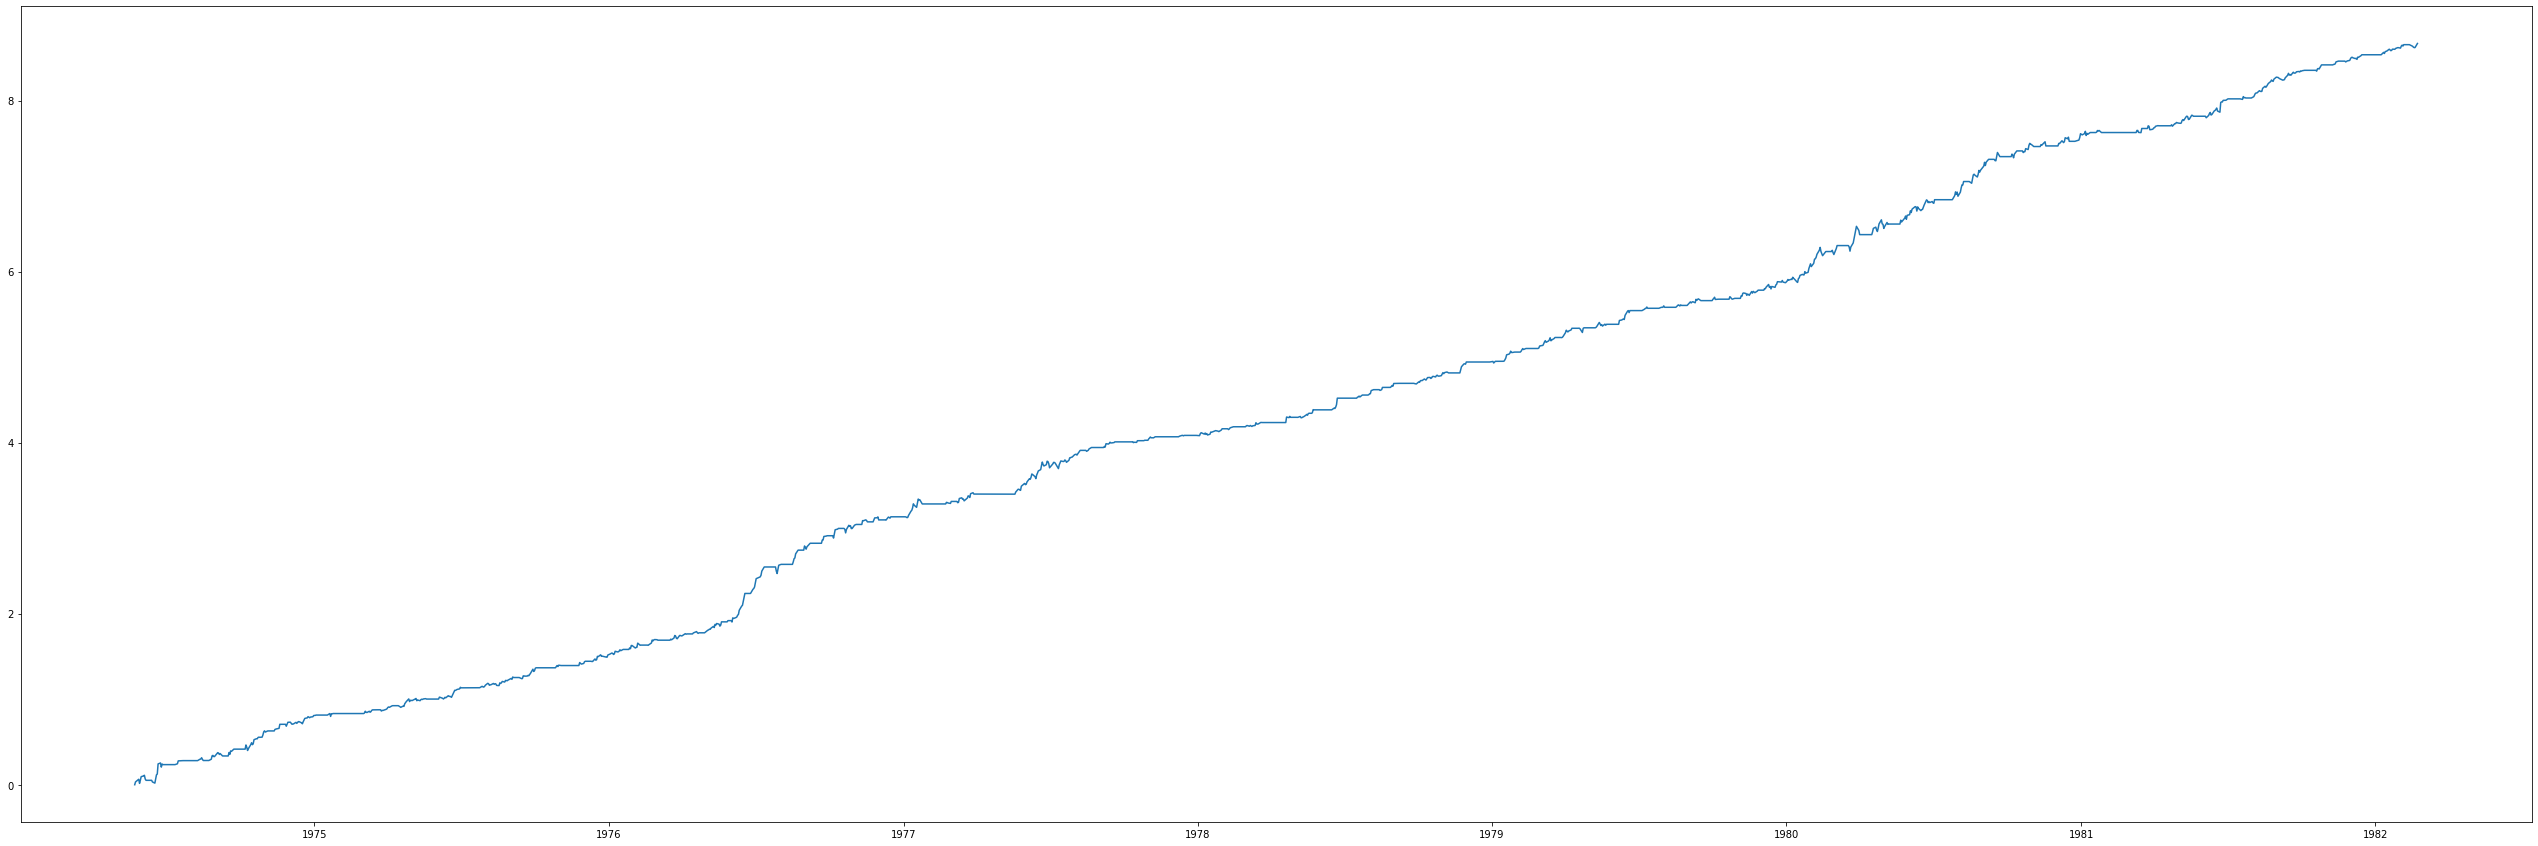

In [50]:
plt.figure(figsize=(45,15))
plt.plot(pnl_df['pnl'].cumsum()/41.250000)
plt.show()

<Figure size 3240x1080 with 0 Axes>

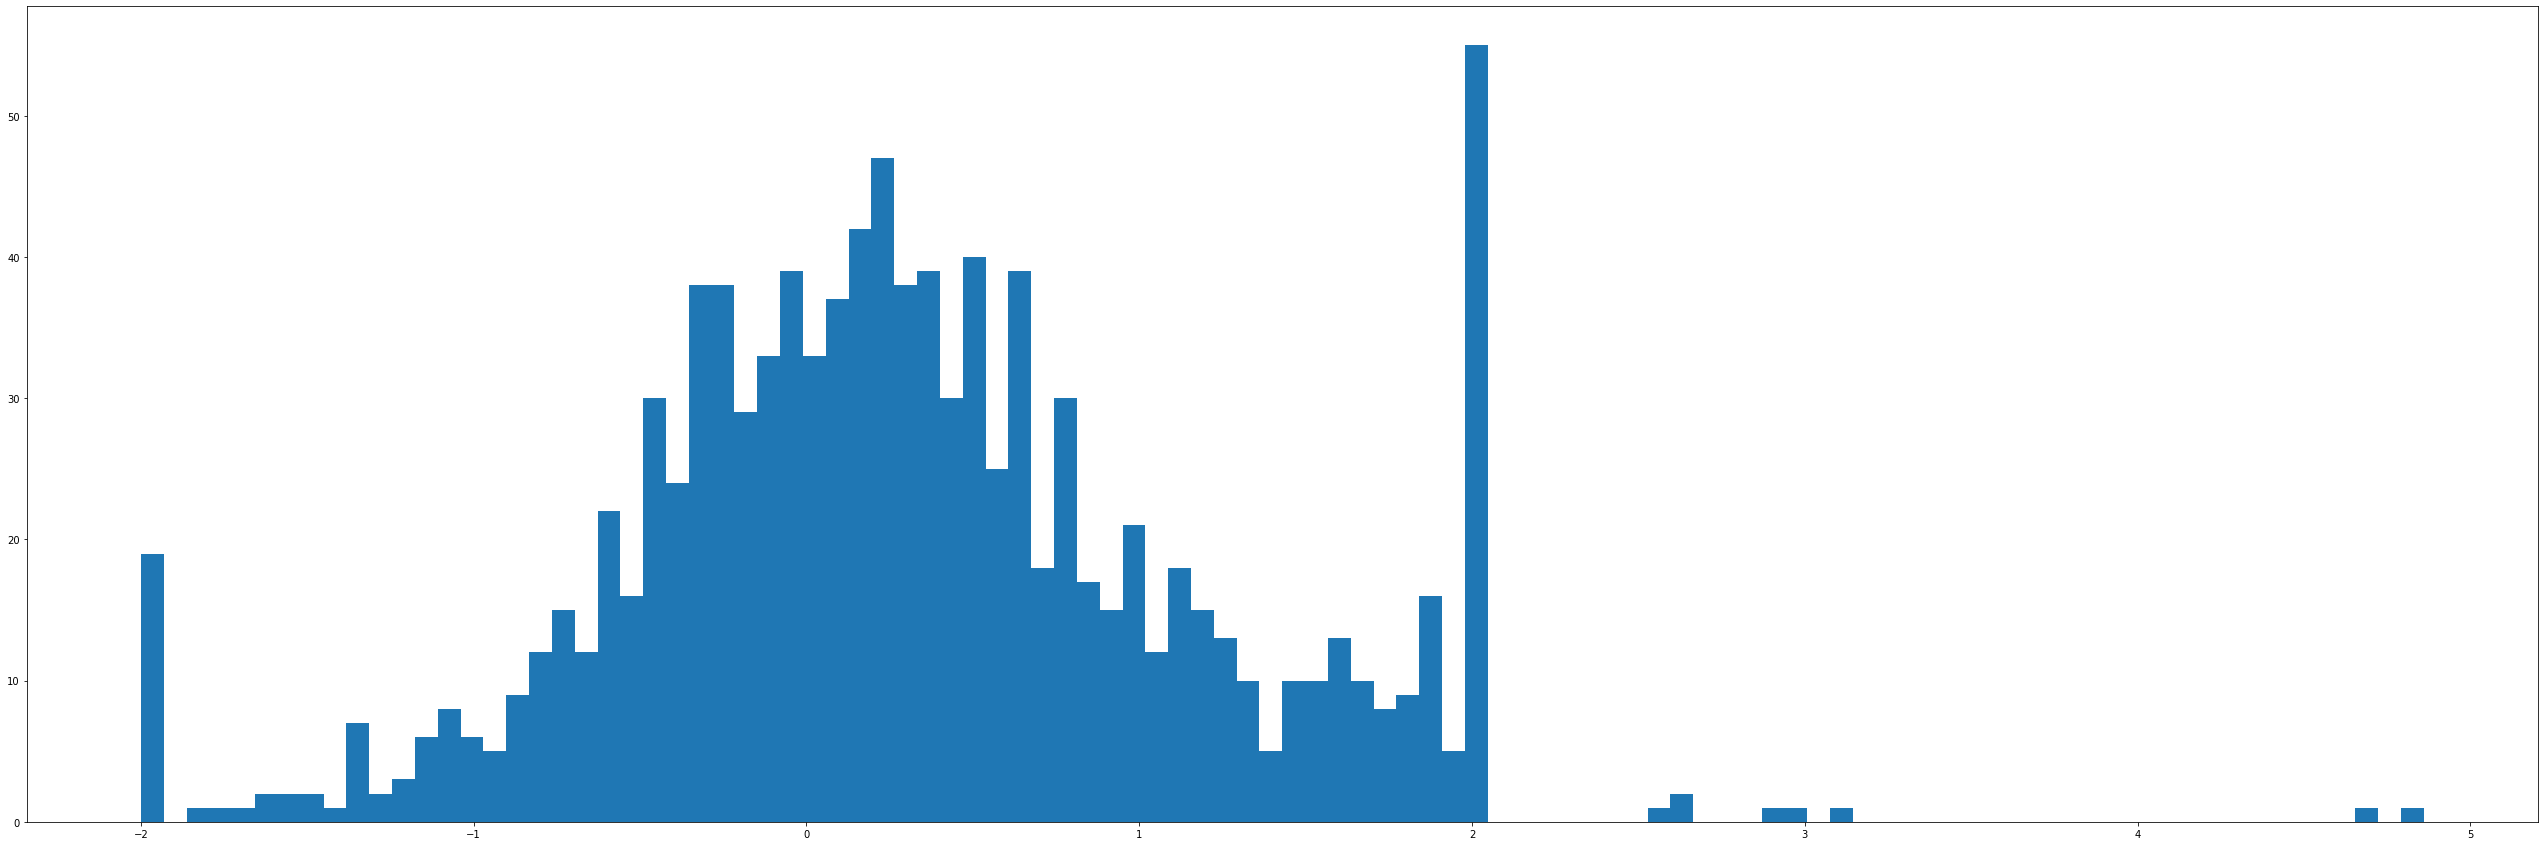

<Figure size 3240x1080 with 0 Axes>

In [51]:
plt.figure(figsize=(45,15))
plt.hist(pnl_df[pnl_df['pnl'] != 0]['pnl'],bins=100)
plt.figure(figsize=(45,15))

[]

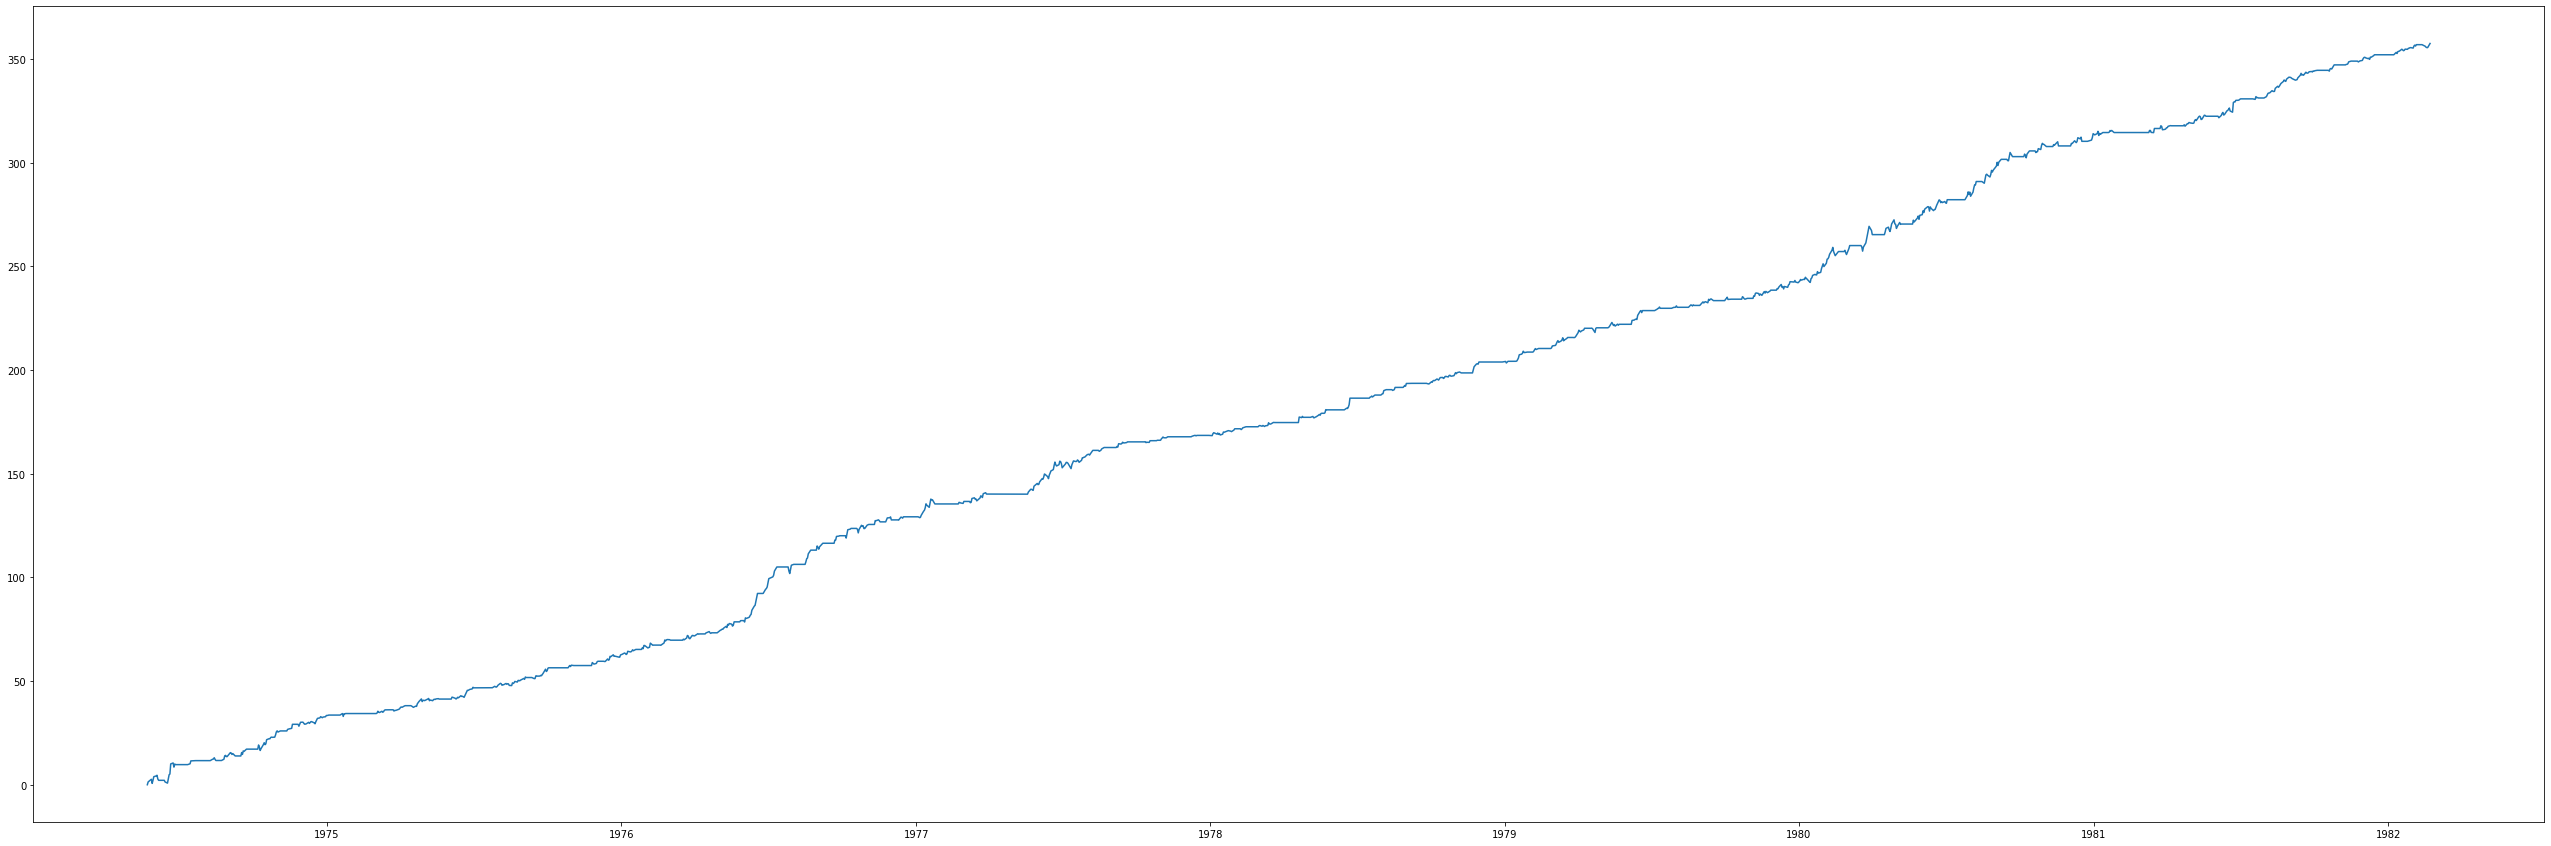

In [46]:
plt.figure(figsize=(45,15))
plt.plot(pnl_df['pnl'].cumsum())
plt.plot()

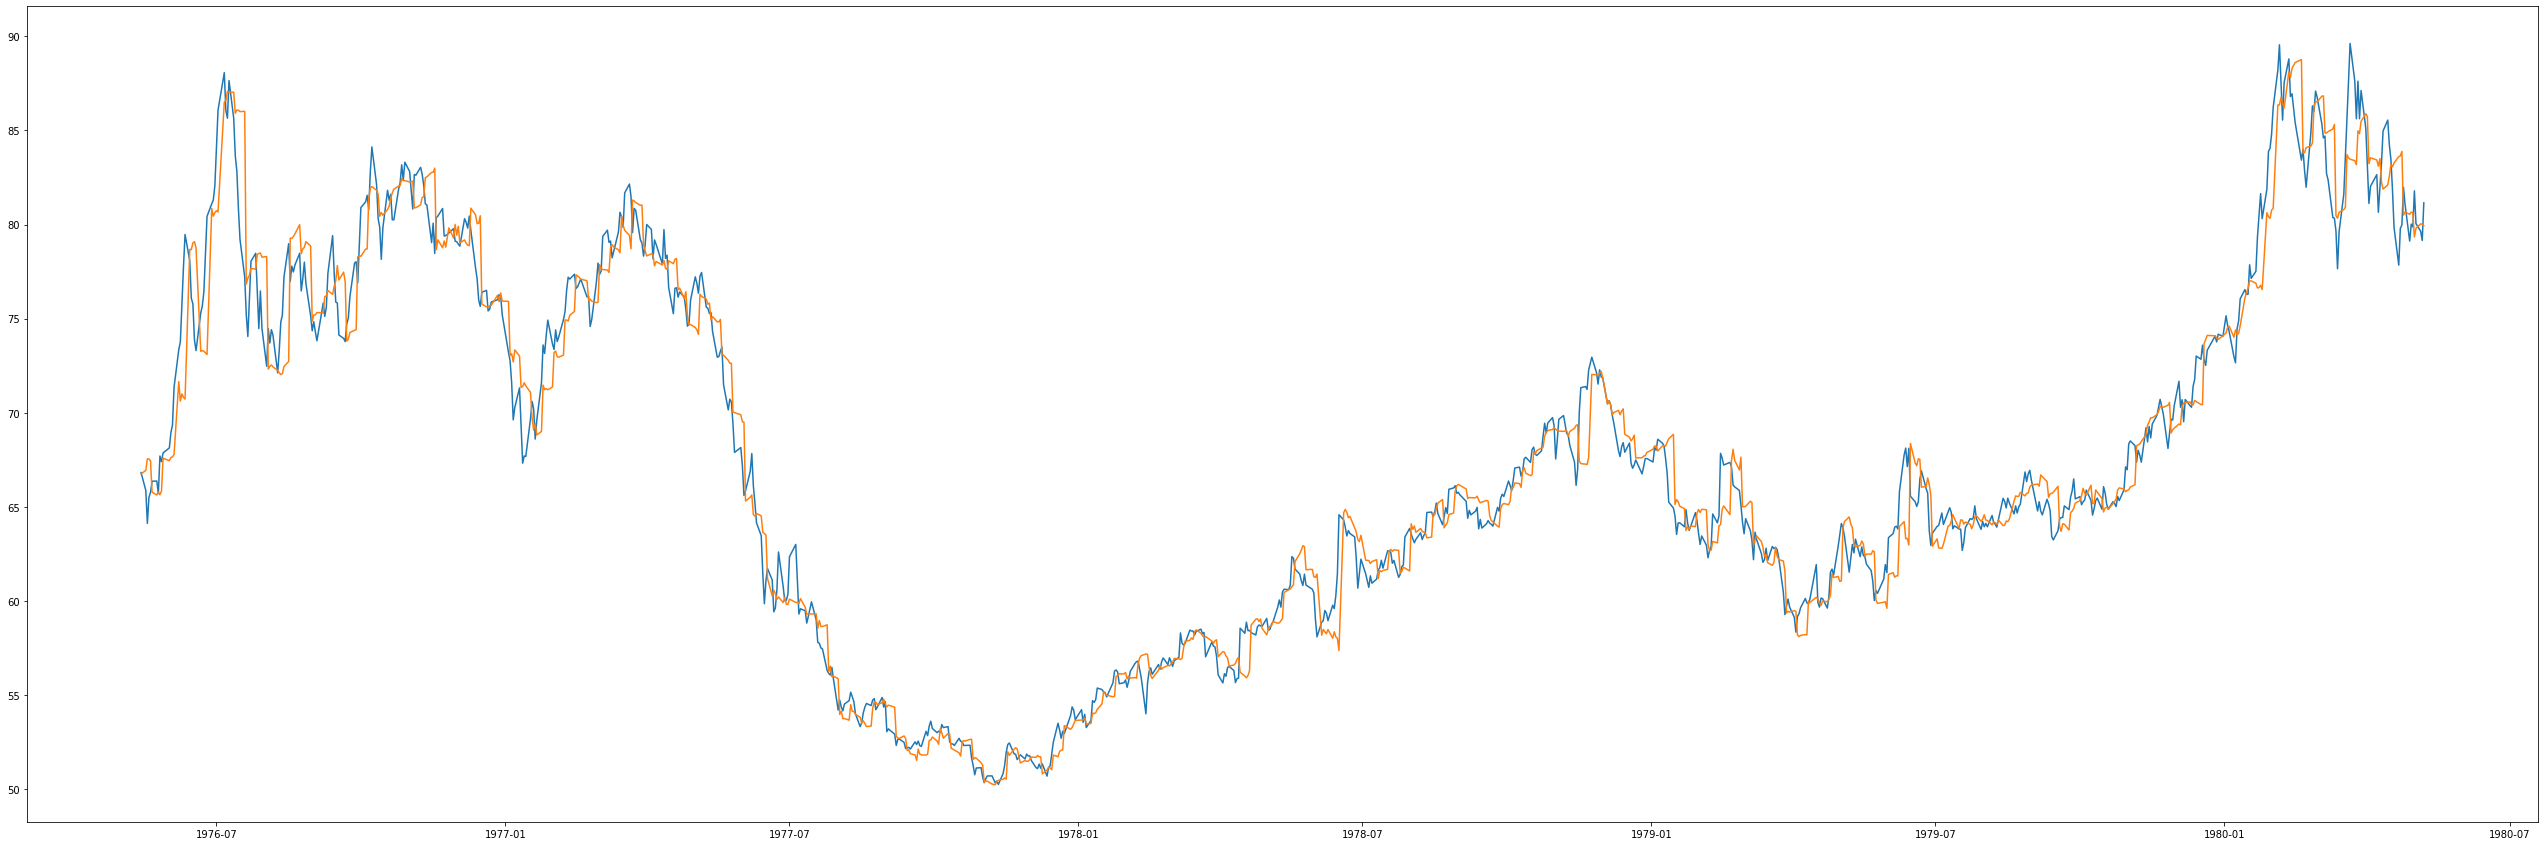

In [53]:
plt.figure(figsize=(45,15))
plt.plot(forecast_merged_df['close'][500:1500])
plt.plot(forecast_merged_df['seasonal_estimate'][500:1500])
plt.show()

# Seasonal backtest

In [48]:
arma_model_event = {

    'dataframe':r'C:\Users\James Stanley\Documents\GitHub\backtest_utilities\data\daily\stocks\BATS_CANE, 1D.csv',
    'forecastHorizon':5,
    'trainDFLength':252,
    'order':(2,2),
    'num_models':50,
    'diff':False,
    'product':'CANE',
    'column':'close',
    'b_adjust':True,

}

In [49]:
import os
import sys

import numpy as np
import pandas as pd

from datetime import datetime

class train_arma:
    
    def __init__(self, event):

        # Read in dataframe
        self.dataframe       = pd.read_csv(event['dataframe'],parse_dates=True,index_col='time')

        # Training information
        self.forecastHorizon = event['forecastHorizon']
        self.trainDFLength   = event['trainDFLength']
        self.order           = event['order']
        self.diff            = event['diff']
        self.product         = event['product']
        self.column          = event['column']
        self.b_adjust        = event['b_adjust']

        # number of mdoels to be trained
        self.num_models      = event['num_models']

        # store l of forecast
        self.forecastList    = []

    def arma_model(self):

        from statsmodels.tsa.arima_model import ARMA

        cacheForecasts = {

            'asofdate':[],
            'pointForecast':[],
            self.column:[],
            'forecastday':[],
            'product_name':[],
            'MA_50':[],
            'MA_diff_50':[],

        }

        cacheMetadata = {

            'asofdate':[],
            'aic':[],
            'bic':[],
            'hqic':[],
            'mae':[],
            'mse':[],
            'forecastHorizon':[],
            'diff':[],
            'trainDFLength':[],
            'num_models':[],
            'order_p':[],
            'order_q':[],
            'time':[],
            'product_name':[],

        }

        for param in range(1,1+self.order[0]):
            cacheMetadata[f'ar.L{param}.{self.column}'] = []

        for param in range(1,1+self.order[1]):
            cacheMetadata[f'ma.L{param}.{self.column}'] = []

        for j in range(1,self.forecastHorizon+1):
            self.forecastList.append(j)

        if self.diff:

            diff   = np.log(self.dataframe[self.column]).diff(1).dropna(axis=0)
    
            i = 0
            while i < self.num_models:

                try:
                    start = datetime.now()

                    # training the model
                    mod = ARMA(diff[i:self.trainDFLength+i], order=self.order)
                    res = mod.fit()
                    
                    # converting log forecast
                    fcast = res.forecast(self.forecastHorizon)

                    # Calculating forecasts
                    cacheForecasts['pointForecast'].append(np.exp(fcast[0])*self.dataframe[self.column][self.trainDFLength+i])
                    cacheForecasts[self.column].append(self.dataframe[self.column][self.trainDFLength+i+1:self.trainDFLength+self.forecastHorizon+i+1])

                    # store model metadata
                    cacheMetadata['asofdate'].append(self.dataframe.index[self.trainDFLength+i])
                    cacheMetadata['aic'].append(res.aic)
                    cacheMetadata['bic'].append(res.bic)
                    cacheMetadata['hqic'].append(res.hqic)
                    cacheMetadata['mae'].append(np.mean(np.abs(res.resid)))
                    cacheMetadata['mse'].append(np.mean(np.square(res.resid)))

                    # event_data
                    cacheMetadata['forecastHorizon'].append(self.forecastHorizon)
                    cacheMetadata['diff'].append(self.diff)
                    cacheMetadata['trainDFLength'].append(self.trainDFLength)
                    cacheMetadata['num_models'].append(self.num_models)
                    cacheMetadata['order_p'].append(self.order[0])
                    cacheMetadata['order_q'].append(self.order[1])
                    cacheMetadata['product_name'].append(self.product)

                    for param in range(1,1+self.order[0]):
                        cacheMetadata[f'ar.L{param}.{self.column}'].append(res.bse[f'ar.L{param}.{self.column}'])

                    for param in range(1,1+self.order[1]):
                        cacheMetadata[f'ma.L{param}.{self.column}'].append(res.bse[f'ma.L{param}.{self.column}'])

                    cacheMetadata['time'].append(datetime.now() - start)

                except:
                    cacheForecasts['pointForecast'].append(self.dataframe[self.column][self.trainDFLength+i+1:self.trainDFLength+self.forecastHorizon+i+1])

                i+=self.forecastHorizon

            # Fixing data formats
            cacheForecasts['pointForecast'] = np.concatenate(cacheForecasts['pointForecast'])
            cacheForecasts['forecastday']   = np.array(self.forecastList*(int(len(cacheForecasts['pointForecast'])/int(self.forecastHorizon))))
            cacheForecasts[self.column]     = np.array(self.dataframe[self.column][1+self.trainDFLength:1+self.trainDFLength+len(cacheForecasts['pointForecast'])])
            cacheForecasts['asofdate']      = np.array(self.dataframe[self.column][1+self.trainDFLength:1+self.trainDFLength+len(cacheForecasts['pointForecast'])].index)
            cacheForecasts['product_name']  = np.array([self.product]*int(len(cacheForecasts['pointForecast'])))
            cacheForecasts['MA_50']         = self.dataframe[self.column].rolling(50).mean()[1+self.trainDFLength:1+self.trainDFLength+len(cacheForecasts['pointForecast'])]
            cacheForecasts['MA_diff_50']    = self.dataframe[self.column].rolling(50).mean().diff(1)[1+self.trainDFLength:1+self.trainDFLength+len(cacheForecasts['pointForecast'])]

            return (pd.DataFrame(cacheForecasts),pd.DataFrame(cacheMetadata))

        if ~self.diff:

            diff   = self.dataframe[self.column].diff(1).dropna(axis=0)

            i = 0
            while i < self.num_models:

                try:
                    start = datetime.now()

                    # training the model
                    mod = ARMA(diff[i:self.trainDFLength+i], order=self.order)
                    res = mod.fit()
                    
                    # converting log forecast
                    fcast = res.forecast(self.forecastHorizon)

                    # Calculating forecasts
                    cacheForecasts['pointForecast'].append(fcast[0]*self.dataframe[self.column][self.trainDFLength+i])
                    cacheForecasts[self.column].append(self.dataframe[self.column][self.trainDFLength+i+1:self.trainDFLength+self.forecastHorizon+i+1])

                    # store model metadata
                    cacheMetadata['asofdate'].append(self.dataframe.index[self.trainDFLength+i])
                    cacheMetadata['aic'].append(res.aic)
                    cacheMetadata['bic'].append(res.bic)
                    cacheMetadata['hqic'].append(res.hqic)
                    cacheMetadata['mae'].append(np.mean(np.abs(res.resid)))
                    cacheMetadata['mse'].append(np.mean(np.square(res.resid)))

                    # event_data
                    cacheMetadata['forecastHorizon'].append(self.forecastHorizon)
                    cacheMetadata['diff'].append(self.diff)
                    cacheMetadata['trainDFLength'].append(self.trainDFLength)
                    cacheMetadata['num_models'].append(self.num_models)
                    cacheMetadata['order_p'].append(self.order[0])
                    cacheMetadata['order_q'].append(self.order[1])
                    cacheMetadata['product_name'].append(self.product)

                    for param in range(1,1+self.order[0]):
                        cacheMetadata[f'ar.L{param}.{self.column}'].append(res.bse[f'ar.L{param}.{self.column}'])

                    for param in range(1,1+self.order[1]):
                        cacheMetadata[f'ma.L{param}.{self.column}'].append(res.bse[f'ma.L{param}.{self.column}'])

                    cacheMetadata['time'].append(datetime.now() - start)

                except:
                    cacheForecasts['pointForecast'].append(self.dataframe[self.column][self.trainDFLength+i+1:self.trainDFLength+self.forecastHorizon+i+1])

                i+=self.forecastHorizon

            # Fixing data formats
            cacheForecasts['pointForecast'] = np.concatenate(cacheForecasts['pointForecast'])
            cacheForecasts['forecastday']   = np.array(self.forecastList*(int(len(cacheForecasts['pointForecast'])/int(self.forecastHorizon))))
            cacheForecasts[self.column]     = np.array(self.dataframe[self.column][1+self.trainDFLength:1+self.trainDFLength+len(cacheForecasts['pointForecast'])])
            cacheForecasts['asofdate']      = np.array(self.dataframe[self.column][1+self.trainDFLength:1+self.trainDFLength+len(cacheForecasts['pointForecast'])].index)
            cacheForecasts['product_name']  = np.array([self.product]*int(len(cacheForecasts['pointForecast'])))
            cacheForecasts['MA_50']         = self.dataframe[self.column].rolling(50).mean()[1+self.trainDFLength:1+self.trainDFLength+len(cacheForecasts['pointForecast'])]
            cacheForecasts['MA_diff_50']    = self.dataframe[self.column].rolling(50).mean().diff(1)[1+self.trainDFLength:1+self.trainDFLength+len(cacheForecasts['pointForecast'])]

            return (pd.DataFrame(cacheForecasts),pd.DataFrame(cacheMetadata))

    def additive_residual_model(self):

        from statsmodels.tsa.seasonal import seasonal_decompose

        self.seasonal_result = seasonal_decompose(self.dataframe[self.column], model="additive",period=252)

        self.trend       = self.seasonal_result.trend
        self.seasonality = self.seasonal_result.seasonal
        self.residuals   = self.seasonal_result.resid

        # Calculate residuals
        self.diff      = False
        self.column    = 'resid'
        
        self.trend       = self.trend.dropna(axis=0)
        self.seasonality = self.seasonality.dropna(axis=0)
        self.dataframe   = self.residuals.dropna(axis=0)

        self.dataframe = self.dataframe.reset_index()
        self.dataframe.set_index('time',inplace=True)
        
        model                      = self.arma_model()
        model[0]['pointForecast']  = model[0]['pointForecast'].cumsum() +\
                                    self.seasonality[self.trainDFLength:self.trainDFLength+self.num_models] +\
                                    self.trend[self.trainDFLength:self.trainDFLength+self.num_models]
        return model


SyntaxError: invalid syntax (<ipython-input-49-d1496dd3512f>, line 9)

In [ ]:
model         = train_arma(arma_model_event)
resid_results = model.additive_residual_model()

c:\Users\James Stanley\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\Users\James Stanley\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueW